#  EVALUATING DIFFERENT MODELS

In [2]:
evaluation_data = [
        {
            "query": "I am hiring for Java developers who can also collaborate effectively with my business teams. Looking for an assessment(s) that can be completed in 40 minutes.",
            "relevant_ids": [
                "Automata - Fix (New)", "Core Java (Entry Level) (New)", "Java 8 (New)",
                "Core Java (Advanced Level) (New)", "Agile Software Development",
                "Technology Professional 8.0 Job Focused Assessment", "Computer Science (New)"
            ]
        },
        {
            "query": "I want to hire new graduates for a sales role in my company, the budget is for about an hour for each test. Give me some options",
            "relevant_ids": [
                "Entry level Sales 7.1 (International)", "Entry Level Sales Sift Out 7.1",
                "Entry Level Sales Solution", "Sales Representative Solution",
                "Sales Support Specialist Solution", "Technical Sales Associate Solution",
                "SVAR - Spoken English (Indian Accent) (New)", "Sales & Service Phone Solution",
                "Sales & Service Phone Simulation", "English Comprehension (New)"
            ]
        },
        {
            "query": "I am looking for a COO for my company in China and I want to see if they are culturally a right fit for our company. Suggest me an assessment that they can complete in about an hour",
            "relevant_ids": [
                "Motivation Questionnaire MQM5", "Global Skills Assessment",
                "Graduate 8.0 Job Focused Assessment"
            ]
        },
        {
            "query": "Content Writer required, expert in English and SEO.",
            "relevant_ids": [
                "Drupal (New)", "Search Engine Optimization (New)",
                "Administrative Professional - Short Form", "Entry Level Sales Sift Out 7.1",
                "General Entry Level – Data Entry 7.0 Solution"
            ]
        },
        {
            "query": "Find me 1 hour long assessment for the below job at SHL Job Description Join a community that is shaping the future of work! SHL, People Science. People Answers. Are you a seasoned QA Engineer with a flair for innovation? Are you ready to shape the future of talent assessment and empower organizations to unlock their full potential? If so, we want you to be a part of the SHL Team! As a QA Engineer, you will be involved in creating and implementing software solutions that contribute to the development of our groundbreaking products. An excellent benefit package is offered in a culture where career development, with ongoing manager guidance, collaboration, flexibility, diversity, and inclusivity are all intrinsic to our culture.  There is a huge investment in SHL currently so there’s no better time to become a part of something transformational. What You Will Be Doing Getting involved in engineering quality assurance and providing inputs when required. Create and develop test plans for various forms of testing. Conducts and/or participates in formal and informal test case reviews. Develop and initiate functional tests and regression tests. Rolling out improvements for testing and quality processes. Essential What we are looking for from you: Development experience – Java or JavaScript, CSS, HTML (Automation) Selenium WebDriver and page object design pattern (Automation) SQL server knowledge Test case management experience. Manual Testing Desirable Knowledge the basic concepts of testing Strong solution-finding experience Strong verbal and written communicator. Get In Touch Find out how this one-off opportunity can help you achieve your career goals by making an application to our knowledgeable and friendly Talent Acquisition team. Choose a new path with SHL. #CareersAtSHL #SHLHiringTalent #TechnologyJobs #QualityAssuranceJobs #CareerOpportunities #JobOpportunities About Us We unlock the possibilities of businesses through the power of people, science and technology. We started this industry of people insight more than 40 years ago and continue to lead the market with powerhouse product launches, groundbreaking science and business transformation. When you inspire and transform people’s lives, you will experience the greatest business outcomes possible. SHL’s products insights, experiences, and services can help achieve growth at scale",
            "relevant_ids": [
                "Automata Selenium", "Automata - Fix (New)", "Automata Front End",
                "JavaScript (New)", "HTML/CSS (New)", "HTML5 (New)", "CSS3 (New)",
                "Selenium (New)", "SQL Server (New)", "Automata - SQL (New)", "Manual Testing (New)"
            ]
        },
        {
            "query": "ICICI Bank Assistant Admin, Experience required 0-2 years, test should be 30-40 mins long",
            "relevant_ids": [
                "Administrative Professional - Short Form", "Verify - Numerical Ability",
                "Financial Professional - Short Form", "Bank Administrative Assistant - Short Form",
                "General Entry Level – Data Entry 7.0 Solution", "Basic Computer Literacy (Windows 10) (New)",
                "Verify - Verbal Ability - Next Generation"
            ]
        },
        {
            "query": "KEY RESPONSIBILITIES: Manage the sound-scape of the station through appropriate creative and marketing interventions to Increase or Maintain the listenership Acts as an interface between Programming & sales team, thereby supporting the sales team by providing creative inputs in order to increase the overall ad spends by clients Build brand Mirchi by ideating fresh programming initiatives on air campaigns, programming led on-ground events & new properties to ensure brand differentiation & thus increase brand recall at station level Invest time in local RJs to grow & develop them as local celebrities Through strong networking, must focus on identifying the best of local talent and ensure to bring the creative minds from the market on board with Mirchi Build radio as a category for both listeners & advertisers People Management Identifying the right talent and investing time in developing them by frequent feedback on their performance Monitor, Coach and mentor team members on a regular basis Development of Jocks as per guidelines Must have an eye to spot the local talent to fill up vacancies locally TECHNICAL SKILLS & QUALIFICATION REQUIRED: Graduation / Post Graduation (Any specialisation) with 8 -12 years of relevant experience Experience in digital content conceptualisation Strong branding focus Must be well-read in variety of areas and must keep up with the latest events in the city / cluster / country Must know to read, write & speak English PERSONAL ATTRIBUTES: Excellent communication skills Good interpersonal skills People management Suggest me some tests for the above jd. The duration should be at most 90 mins",
            "relevant_ids": [
                "SHL Verify Interactive - Inductive Reasoning",
                "Occupational Personality Questionnaire OPQ32r"
            ]
        }
    ]

In [1]:

import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from tqdm import tqdm

# --- Evaluation Metrics ---
def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    hits = sum(1 for item in recommended_k if item in relevant)
    return hits / len(relevant) if relevant else 0.0



def average_precision_at_k(recommended, relevant, k):
    score = 0.0
    hits = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if relevant else 0.0


# --- Models to Benchmark ---
models_to_test = [
    "all-MiniLM-L6-v2",
    "all-distilroberta-v1",
    "all-mpnet-base-v2",
    "sentence-t5-base"
]

c:\Users\Shiv\Desktop\SHL\project\local-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:



# --- Load Metadata ---
with open("shl_assessments_complete.json", "r") as f:
    assessments = json.load(f)

# --- Generate Embedding Texts ---
texts = [
    f"{a['name']}. {a['description']}. Test Types: {', '.join(a['test_types'])}. "
    f"Remote: {a['remote_support']}. Adaptive: {a['adaptive_support']}. Duration: {a['duration']} minutes."
    for a in assessments
]

# --- Benchmarking Function ---
def benchmark_model(model_name, k=10):
    print(f"\n🔍 Benchmarking: {model_name}")
    model = SentenceTransformer(model_name)

    # Encode and normalize document embeddings
    embeddings = model.encode(texts, show_progress_bar=True)
    embeddings = normalize(embeddings)

    # Build FAISS index
    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings)

    recalls = []
    maps = []

    for example in evaluation_data:
        query_embedding = normalize(model.encode([example["query"]]))
        _, indices = index.search(query_embedding, k)
        top_names = [assessments[i]['name'] for i in indices[0]]

        rec = recall_at_k(top_names, example["relevant_ids"], k)
        ap = average_precision_at_k(top_names, example["relevant_ids"], k)

        recalls.append(rec)
        maps.append(ap)

        # print(f"Query: {example['query']}")
        # print(f"Recall@{k}: {rec:.2f} | MAP@{k}: {ap:.2f}")
        # print("Top Results:", top_names[:k])
        # print("-" * 50)
        
    mean_recall = np.mean(recalls)
    mean_map = np.mean(maps)

    print(f"📊 Overall for {model_name}:")
    print(f"Mean Recall@{k}: {mean_recall:.3f}")
    print(f"Mean MAP@{k}: {mean_map:.3f}")
    print("-" * 50)
    
    return {
        "Model": model_name,
        f"Recall@{k}": mean_recall,
        f"MAP@{k}": mean_map
    }

# --- Run All Models ---

results = []
for model_name in models_to_test:
    
    res = benchmark_model(model_name, k=3) # k = 3, as suggested by the pdf guidelines
    results.append(res)



🔍 Benchmarking: all-MiniLM-L6-v2


Batches: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


📊 Overall for all-MiniLM-L6-v2:
Mean Recall@3: 0.043
Mean MAP@3: 0.071
--------------------------------------------------

🔍 Benchmarking: all-distilroberta-v1


Batches: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


📊 Overall for all-distilroberta-v1:
Mean Recall@3: 0.057
Mean MAP@3: 0.103
--------------------------------------------------

🔍 Benchmarking: all-mpnet-base-v2


Batches: 100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


📊 Overall for all-mpnet-base-v2:
Mean Recall@3: 0.098
Mean MAP@3: 0.222
--------------------------------------------------

🔍 Benchmarking: sentence-t5-base


Batches: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


📊 Overall for sentence-t5-base:
Mean Recall@3: 0.043
Mean MAP@3: 0.095
--------------------------------------------------


## best model == all-mpnet-base-v2
📊 Overall for all-mpnet-base-v2: \
Mean Recall@3: 0.098 \
Mean MAP@3: 0.222

In [4]:
import pandas as pd
df_results = pd.DataFrame(results)

In [5]:
df_results

,Model,Recall@3,MAP@3
0,all-MiniLM-L6-v2,0.042857,0.071429
1,all-distilroberta-v1,0.057143,0.103175
2,all-mpnet-base-v2,0.097959,0.222222
3,sentence-t5-base,0.042857,0.095238


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

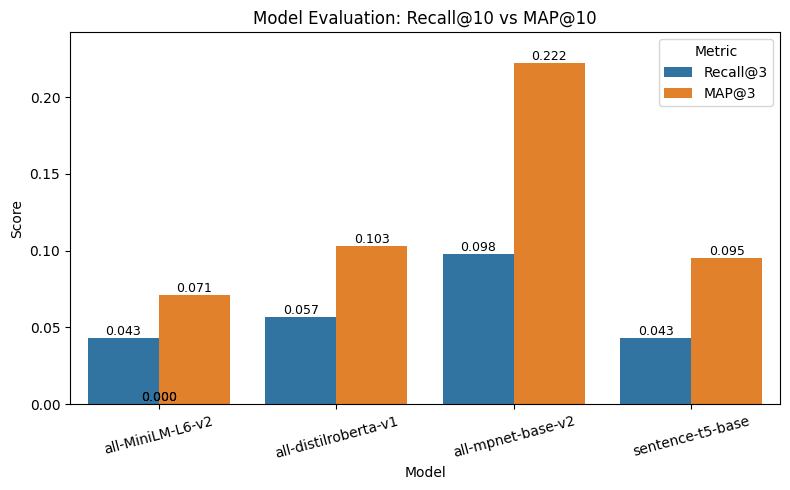

In [8]:
# Melt the DataFrame for grouped barplot
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")

# Annotate scores on top of bars
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.3f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9)

plt.title("Model Evaluation: Recall@10 vs MAP@10")
plt.xticks(rotation=15)
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, max(df_melted["Score"]) + 0.02)
plt.legend(title="Metric")
plt.tight_layout()

plt.savefig("model_evaluation_scores.png", dpi=300)


plt.show()

In [6]:
# # TESTING


# def evaluate(evaluation_data, k = 10):
#     recalls = []
#     maps = []
    
#     for example in evaluation_data:
#         query = example['query']
#         relevant_ids = set(example['relevant_ids'])
        
#         query_embedding = normalize(model.encode([query]))
#         scores, indices = index.search(query_embedding, k)
        
#         recommended_names = []
#         for i in indices[0]:
#             rn = assessments[i]['name']
#             recommended_names.append(rn)
        
#         recall_val = recall_at_k(recommended_names, relevant_ids, k)
#         ap = average_precision_at_k(recommended_names, relevant_ids, k)
        
#         recalls.append(recall_val)
#         maps.append(ap)
        
#         print(f"\n🔍 Query: {query[:200]}")
#         print(f"✅ Recall@{k}: {recall_val:.2f} | MAP@{k}: {ap:.2f}" )
#         print("Top Recommendations : ", recommended_names)
        
#     print("\n📊 Overall Evaluation:")
#     print(f"Mean Recall@{k}: {np.mean(recalls):.3f}")
#     print(f"Mean AP@{k} (MAP@{k}): {np.mean(maps):.3f}")
    




# evaluate(evaluation_data, k=10)
    
            